In [1]:
import json
import cv2
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

from pathlib import Path
from dotenv import load_dotenv

import os

from scipy import ndimage
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

from yolov5.utils.plots import Annotator, save_one_box
from sklearn.metrics import accuracy_score

from utils.preprocess import recovery_rotated_bounding
from utils.yolo import get_teeth_ROI, crop_by_xyxy
from utils.edge import integral_intensity_projection

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

%matplotlib inline


In [ ]:
model = torch.hub.load(r'..\YOLO', 'custom', path=r'..\YOLO\weights\8-bound.pt', source='local')
data_dir = '..' / Path(os.getenv('DATASET_DIR'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


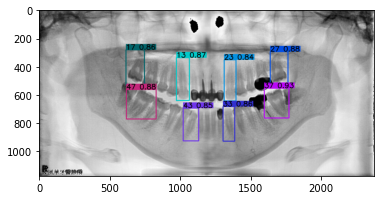

In [3]:
image_names = list(data_dir.glob('00008026.jpg'))

image_name = image_names[0]
filename = image_name.stem

img = cv2.imread(image_name, 0)

results = model(image_name)
rendered_results = results.render()
detected_results = model(image_name)

plt.imshow(1 - rendered_results[0])
plt.show()


In [4]:
# def temp_bak(bounds):
#     for xyxy in bounds:
#         mid_xy = torch.stack(((xyxy[0] + xyxy[2]) / 2, (xyxy[1] + xyxy[3]) / 2))
#
#         mid_x.append(mid_xy[0])
#         mid_y.append(mid_xy[1])
#
#     for i, mid_x_index in enumerate(mid_x_indices[:-1]):
#         seq_1.append(mid_x_index)
#
#     diff_in_mid_y = torch.abs(mid_y[:-1] - mid_y[1:])
#     diff_in_mid_y, diff_in_mid_y_indices = torch.sort(diff_in_mid_y, descending=True)
#
#     upper_teeth = mid_y_indices
#     lower_teeth = mid_y_indices
#     for seek in range(len(diff_in_mid_y_indices)):
#         split_point = diff_in_mid_y_indices[seek] + 1
#         upper_teeth = mid_y_indices[:split_point]
#         lower_teeth = mid_y_indices[split_point:]
#
#         if len(upper_teeth) <= 4 and len(lower_teeth) <= 4:
#             break
#
#     return upper_teeth, lower_teeth

def temp(bounds, classes):
    mid_x = []
    mid_y = []
    for xyxy in bounds:
        mid_xy = torch.stack(((xyxy[0] + xyxy[2]) / 2, (xyxy[1] + xyxy[3]) / 2))

        mid_x.append(mid_xy[0])
        mid_y.append(mid_xy[1])

    mid_y = torch.stack(mid_y)
    mid_y, mid_y_indices = torch.sort(mid_y)

    classes_by_y = classes[mid_y_indices]

    mid_x = torch.stack(mid_x)

    # upper lower confuse check
    classes_by_y_flags = classes_by_y < 30
    true_tensor = torch.tensor([True], device=device)
    false_tensor = torch.tensor([False], device=device)
    classes_by_y_flags = torch.cat([true_tensor, classes_by_y_flags, false_tensor])

    classes_by_y_flag_change = torch.logical_xor(classes_by_y_flags[:-1], classes_by_y_flags[1:])
    classes_by_y_flag_change_count = torch.sum(classes_by_y_flag_change[1:-1])

    upper_teeth_indices = torch.tensor([], device=device, dtype=torch.long)
    lower_teeth_indices = torch.tensor([], device=device, dtype=torch.long)
    if classes_by_y_flag_change_count < 1:
        upper_teeth_count = torch.sum(classes_by_y_flags)

        upper_teeth_indices = mid_y_indices if upper_teeth_count > 0 else upper_teeth_indices
        lower_teeth_indices = mid_y_indices if upper_teeth_count == 0 else lower_teeth_indices
    elif classes_by_y_flag_change_count < 2:
        change_idx = torch.where(classes_by_y_flag_change == True)[0] + 1
        upper_teeth_indices = mid_y_indices[:change_idx]
        lower_teeth_indices = mid_y_indices[change_idx:]
    else:
        pass
        print(classes_by_y)
        print(classes_by_y_flags)
        print(classes_by_y_flag_change)

    # print(upper_teeth_indices)
    # print(lower_teeth_indices)

    upper_teeth = mid_x[upper_teeth_indices.long()]
    lower_teeth = mid_x[lower_teeth_indices.long()]

    upper_teeth_sorted, upper_teeth_sorted_indices = torch.sort(upper_teeth)
    lower_teeth_sorted, lower_teeth_sorted_indices = torch.sort(lower_teeth)

    upper_teeth_indices = upper_teeth_indices[upper_teeth_sorted_indices] if len(
        upper_teeth_indices) > 0 else upper_teeth_indices
    lower_teeth_indices = lower_teeth_indices[lower_teeth_sorted_indices] if len(
        lower_teeth_indices) > 0 else lower_teeth_indices

    classes_sorted_indices = torch.cat([upper_teeth_indices, lower_teeth_indices])
    classes_sorted = classes[classes_sorted_indices]

    print(classes_sorted)


# a = torch.randperm(8)[:torch.randint(1, 8, (1,))]
a = [0, 4, 2, 3, 1, 5, 6, 7]
# print(a)

cls_order_list = torch.tensor(list(map(int, detected_results.names)), device=device, dtype=torch.int)
tooth_bounds = detected_results.xyxy[0][:, :4]
tooth_cls = detected_results.xyxy[0][:, 5].type(torch.long)
print(cls_order_list[tooth_cls])
tooth_cls = detected_results.xyxy[0][a, 5].type(torch.long)

temp(tooth_bounds, cls_order_list[tooth_cls])
print(cls_order_list[tooth_cls])

# detected_results.xyxy[0][:, 5].type(torch.int)



tensor([37, 47, 27, 13, 17, 33, 43, 23], device='cuda:0', dtype=torch.int32)
tensor([47, 27, 13, 23, 37, 17, 33, 43], device='cuda:0', dtype=torch.int32)
tensor([ True, False,  True,  True,  True, False,  True, False, False, False], device='cuda:0')
tensor([ True,  True, False, False,  True,  True,  True, False, False], device='cuda:0')
tensor([], device='cuda:0', dtype=torch.int32)
tensor([37, 17, 27, 13, 47, 33, 43, 23], device='cuda:0', dtype=torch.int32)


169
(1175,)
109
(1175,)
76
(1175,)
82
(1175,)
141
(1175,)
200
(1175,)
169
(1175,)
183
(1175,)
176
(1175,)
220
(1175,)
178
(1175,)
237
(1175,)


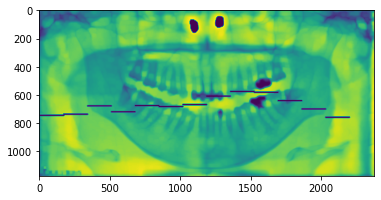

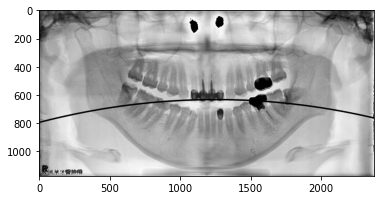

In [5]:
clahe = cv2.createCLAHE(clipLimit=0.2)


def foo(x, a, b, c):
    return a * x ** 2 + b * x + c
    # return a * np.exp(-b * x) + c


def fit_curve_by_img(pano_img, show=False):
    area_number = 14

    kernel = np.ones((5, 5), np.uint8)
    pano_img = gaussian_filter(pano_img, sigma=5)
    pano_img = cv2.erode(pano_img, kernel, iterations=3)
    pano_img = clahe.apply(pano_img)

    im0 = pano_img.copy()

    height, width = im0.shape
    w_area = width // area_number
    # split_line = range(w_area, width, w_area)
    split_line = np.hstack([
        [width // 2 + w_area * i for i in range(area_number // 2)],
        [width // 2 - w_area * i for i in range(area_number // 2)]
    ])

    y_line = []
    x_line = []
    for idx, x_cavity in enumerate(split_line):
        margin = 60
        # im_area = im0[height // 2 - margin:height // 2 + margin, i - w_area:i]
        padding = 500
        im_area = im0[:, x_cavity - w_area:x_cavity]

        if idx % (area_number // 2) == 0:
            im_area = im0[padding:-padding, x_cavity - w_area:x_cavity]
            sum_area = np.sum(im_area, axis=1)

            y_cavity = sum_area.argmin() + padding
        else:
            sum_area = np.sum(im_area, axis=1)

            y_cavity_pre = y_line[idx - 1] - padding
            print(y_cavity_pre)
            print(sum_area.shape)
            y_cavity = sum_area[y_cavity_pre - margin:y_cavity_pre + margin].argmin() + y_cavity_pre - margin + padding

        y_line.append(y_cavity)
        x_line.append(x_cavity - w_area // 2)

    x_line = np.array(x_line)
    y_line = np.array(y_line)

    # diff_y_line = np.abs(y_line[:-1] - y_line[1:])
    # is_diff_gt_threshold = diff_y_line < 100

    # seek_l, seek_r = area_number // 2 - 1, area_number // 2
    # seek_l, seek_r = len(diff_y_line) // 2 - 1, len(diff_y_line) // 2
    # while is_diff_gt_threshold[seek_l] and seek_l > 1:
    #     seek_l -= 1
    # seek_l += 1
    # while is_diff_gt_threshold[seek_r] and seek_r < len(diff_y_line) - 2:
    #     seek_r += 1
    # seek_r += 1

    # y_line = y_line[seek_l:seek_r]
    # x_line = x_line[seek_l:seek_r]

    if show:
        for x, y in zip(x_line, y_line):
            im0 = cv2.line(im0, (x - w_area // 2, y), (x + w_area // 2, y), color=255, thickness=10)
        plt.imshow(1 - im0)
        plt.show()

    popt, pcov = curve_fit(foo, x_line, y_line)

    return lambda x: foo(x, *popt)


image_names = list(data_dir.glob('*.jpg'))
image_name = image_names[0]

im_show = cv2.imread(image_name, 0)
curve_func = fit_curve_by_img(im_show, show=True)

draw_x = np.linspace(0, im_show.shape[1] - 1, 1000).astype(np.int32)
draw_y = np.array(list(map(curve_func, draw_x))).astype(np.int32)
draw_points = (np.asarray([draw_x, draw_y]).T).astype(np.int32)  # needs to be int32 and transposed

im0 = cv2.polylines(im_show, [draw_points], False, 255, thickness=10)
im0 = im_show

plt.gray()
plt.imshow(1 - im0)
plt.show()




169
(1175,)
109
(1175,)
76
(1175,)
82
(1175,)
141
(1175,)
200
(1175,)
169
(1175,)
183
(1175,)
176
(1175,)
220
(1175,)
178
(1175,)
237
(1175,)


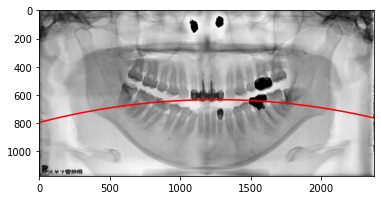

<function __main__.get_classify_function.<locals>.quadrant_classify(pt, show=False)>

In [6]:
def get_classify_function(im, show=False, gray=False):
    if gray:
        im_g = im.copy()
    else:
        im_g = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    height, width = im_g.shape
    middle_height, middle_width = height // 2, width // 2

    vertical_test_curve = fit_curve_by_img(im_g)

    if show:
        draw_x = np.linspace(0, width - 1, 1000).astype(np.int32)
        draw_y = np.array(list(map(vertical_test_curve, draw_x))).astype(np.int32)

        plt.imshow(1 - im_g, cmap='gray')
        plt.plot(draw_x, draw_y, 'r')

        plt.show()

    def quadrant_classify(pt, show=False):
        x, y = pt

        curve_point = vertical_test_curve(x)

        if show:
            print(curve_point)

        is_below = y > curve_point
        is_right = x > middle_width

        if not is_right and not is_below:
            return '1'
        elif is_right and not is_below:
            return '2'
        if is_right and is_below:
            return '3'
        else:
            return '4'

    return quadrant_classify


get_classify_function(img, show=True, gray=True)


In [7]:
image_names = list(data_dir.glob('*.jpg'))
image_names = image_names[:10]

targets = ['13', '23', '33', '43', '17', '27', '37', '47']
results = {}

acc_total = []
for idx, image_name in enumerate(image_names):
    im_temp = cv2.imread(image_name, 0)
    json_name = str(image_name).replace('jpg', 'json')

    with open(json_name, 'r') as f:
        data = json.load(f)

    shapes = data['shapes']
    try:
        labels = np.hstack([int(shape['label']) for shape in shapes if shape['label'] in targets])
        gt_bounds = np.vstack([np.hstack(shape['points']) for shape in shapes if shape['label'] in targets])
    except Exception:
        labels = {shape['label'] for shape in shapes}
        print(idx, labels)
        continue

    classify_function = get_classify_function(im_temp, show=False, gray=True)

    gt_bounds_mid = np.transpose(
        np.vstack([
            (gt_bounds[:, 0] + gt_bounds[:, 2]) / 2,
            (gt_bounds[:, 1] + gt_bounds[:, 3]) / 2
        ])
    )

    labels = labels // 10
    number_pos = np.fromiter((classify_function(xi) for xi in gt_bounds_mid), gt_bounds_mid.dtype)

    array_acc = labels == number_pos

    acc = round(np.sum(array_acc) / len(array_acc) * 100)

    results[image_name.name] = {'acc': acc}
    acc_total.append(acc)

    # print(labels)
    # print(number_pos)
    print(idx)

results


169
(1175,)
109
(1175,)
76
(1175,)
82
(1175,)
141
(1175,)
200
(1175,)
169
(1175,)
183
(1175,)
176
(1175,)
220
(1175,)
178
(1175,)
237
(1175,)
0
142
(1175,)
121
(1175,)
161
(1175,)
101
(1175,)
67
(1175,)
88
(1175,)
142
(1175,)
121
(1175,)
110
(1175,)
55
(1175,)


ValueError: attempt to get argmin of an empty sequence

In [ ]:
image_names = list(data_dir.glob('*.jpg'))
image_names = image_names[27:]

targets = ['13', '23', '33', '43', '17', '27', '37', '47']
results = {}

for idx, image_name in enumerate(image_names):
    json_name = str(image_name).replace('jpg', 'json')

    with open(json_name, 'r') as f:
        data = json.load(f)

    shapes = data['shapes']
    try:
        labels = np.hstack([int(shape['label']) for shape in shapes if shape['label'] in targets])
        gt_bounds = np.vstack([np.hstack(shape['points']) for shape in shapes if shape['label'] in targets])
    except Exception:
        labels = {shape['label'] for shape in shapes}
        print(idx, labels)
        continue

    indices = temp(torch.from_numpy(gt_bounds))

    upper_label = labels[indices[0]]
    lower_label = labels[indices[1]]

    upper_teeth_checker = np.sum(upper_label < 30) / len(indices[0])
    lower_teeth_checker = np.sum(lower_label > 30) / len(indices[1])

    if upper_teeth_checker < 1 or lower_teeth_checker < 1:
        print(labels)
        print(upper_label)

        results[image_name.name] = {
            'upper_teeth_checker': upper_teeth_checker,
            'lower_teeth_checker': lower_teeth_checker,
        }

        break

results


In [ ]:
image_names = list(data_dir.glob('*.jpg'))
image_names = image_names[:]

targets = ['13', '23', '33', '43', '17', '27', '37', '47']
# targets = ['13', '23', '33', '43']
results = {}

bin_data_upper = []
bin_data_upper_molar = []
bin_data_upper_canine = []
bin_data_lower = []
bin_data_lower_molar = []
bin_data_lower_canine = []
bin_data_diff = []
for idx, image_name in enumerate(image_names):
    json_name = str(image_name).replace('jpg', 'json')

    with open(json_name, 'r') as f:
        data = json.load(f)

    shapes = data['shapes']
    try:
        labels = np.hstack([int(shape['label']) for shape in shapes if shape['label'] in targets])
        gt_bounds = np.vstack([np.hstack(shape['points']) for shape in shapes if shape['label'] in targets])
    except ValueError:
        # labels = {shape['label'] for shape in shapes}
        # print(idx, labels)
        continue

    gt_bounds_mid_y = np.round((gt_bounds[:, 1] + gt_bounds[:, 3]) / 20)

    lower_bound = gt_bounds_mid_y[labels > 30]
    upper_bound = gt_bounds_mid_y[labels < 30]

    # lower_bound_canine = gt_bounds_mid_y[
    #     np.logical_and(labels > 30, labels % 10 == 3)
    # ]
    # lower_bound_molar = gt_bounds_mid_y[
    #     np.logical_and(labels > 30, labels % 10 == 7)
    # ]
    #
    # upper_bound_canine = gt_bounds_mid_y[
    #     np.logical_and(labels < 30, labels % 10 == 3)
    # ]
    # upper_bound_molar = gt_bounds_mid_y[
    #     np.logical_and(labels < 30, labels % 10 == 7)
    # ]

    try:
        # lower_bound = lower_bound_canine.min() - lower_bound_molar.max()
        # upper_bound = upper_bound_canine.min() - upper_bound_molar.max()
        diff = lower_bound.min() - upper_bound.max()

        if diff < 10:
            a = list(labels)
            b = {i: a.count(i) for i in a if a.count(i) > 1}

            print(b)
            print(image_name)
    except ValueError:
        continue

    # bin_data_upper.append(upper_bound)
    # bin_data_lower.append(lower_bound)

    # bin_data_lower_molar.append(lower_bound_molar)
    # bin_data_lower_canine.append(lower_bound_canine)
    # bin_data_upper_molar.append(upper_bound_molar)
    # bin_data_upper_canine.append(upper_bound_canine)

    bin_data_diff.append(diff)

bin_data_diff = np.hstack(bin_data_diff)

# bin_data_upper = np.hstack(bin_data_upper)
# bin_data_lower = np.hstack(bin_data_lower)

# bin_data_lower_canine = np.hstack(bin_data_lower_canine)
# bin_data_lower_molar = np.hstack(bin_data_lower_molar)
#
# bin_data_upper_canine = np.hstack(bin_data_upper_canine)
# bin_data_upper_molar = np.hstack(bin_data_upper_molar)

# plt.hist(bin_data_lower, bins=np.arange(bin_data_lower.min(), bin_data_lower.max() + 1), color='g')
# plt.hist(bin_data_upper, bins=np.arange(bin_data_upper.min(), bin_data_upper.max() + 1), color='r')
# plt.show()

# plt.hist(bin_data_lower_canine, bins=np.arange(bin_data_lower_canine.min(), bin_data_lower_canine.max() + 1), color='g')
# plt.hist(bin_data_lower_molar, bins=np.arange(bin_data_lower_molar.min(), bin_data_lower_molar.max() + 1), color='r')
# plt.show()
#
# plt.hist(bin_data_upper_canine, bins=np.arange(bin_data_upper_canine.min(), bin_data_upper_canine.max() + 1), color='g')
# plt.hist(bin_data_upper_molar, bins=np.arange(bin_data_upper_molar.min(), bin_data_upper_molar.max() + 1), color='r')
# plt.show()

plt.hist(bin_data_diff, bins=np.arange(bin_data_diff.min(), bin_data_diff.max() + 1), color='r')
plt.show()

# results

In [22]:
image_names = list(data_dir.glob('*.jpg'))
image_names = image_names[:10]

all_result = model(image_names)
teeth_xyxy = all_result.xyxy

for idx, tooth_xyxy in enumerate(teeth_xyxy):
    # *xyxy, conf, cls = tooth_xyxy
    xyxy = tooth_xyxy[:, :4]
    cls = tooth_xyxy[:, 5].to(torch.bool)

    cls = cls_order_list[cls]
    print(cls)

    break





# print(tooth_cls)

# for result in all_result:
#     print(result)
#     break



tensor([13, 17, 23, 33, 37, 43, 47], device='cuda:0', dtype=torch.int32)
